In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'

import os
import cv2
import numpy as np
from matplotlib import pyplot as plt

In [2]:
def imshow(imgs, figsize=(12.5, 10), **kwargs):
    """ Utility function for dispalying an array of images. """
    if not isinstance(imgs, list): imgs = [imgs]
    cols = int(np.ceil(np.sqrt(len(imgs))))
    rows = cols-1 if (cols*cols-len(imgs)== cols) else cols
    fig, axs = plt.subplots(rows, cols, figsize=figsize, squeeze=False)
    for img, ax in zip(imgs, axs.flatten()): 
        cm, sl = ('gray', np.s_[:, :]) if img.ndim == 2 else (None, np.s_[...,::-1])
        ax.imshow(img[sl], cmap=cm, **kwargs)
    for ax in axs.flatten(): ax.axis('off')
    plt.tight_layout()

In [13]:
def write_aruco_marker(out_dir, aruco_dict):
    """ Write images of the markers with id 0,1,2,3 to the specified dir. """
    path_frmt = os.path.join(out_dir, '{id}-4x4-50.png')
    os.makedirs(markers_dir, exist_ok=True)

    for i in range(4):
        img = cv2.aruco.drawMarker(ar_dict, i, 500)
        cv2.imwrite(path_frmt.format(id=i), img)
        
ar_dict = cv2.aruco.Dictionary_get(cv2.aruco.DICT_4X4_50)
markers_dir = os.path.expanduser('~/Desktop/aruco_marker')
write_aruco_marker(markers_dir, ar_dict)

In [4]:
cm_img = cv2.imread('/Users/Johannes/Desktop/test-image-4.jpg')
cm_img_gray = cv2.cvtColor(cm_img, cv2.COLOR_BGR2GRAY)

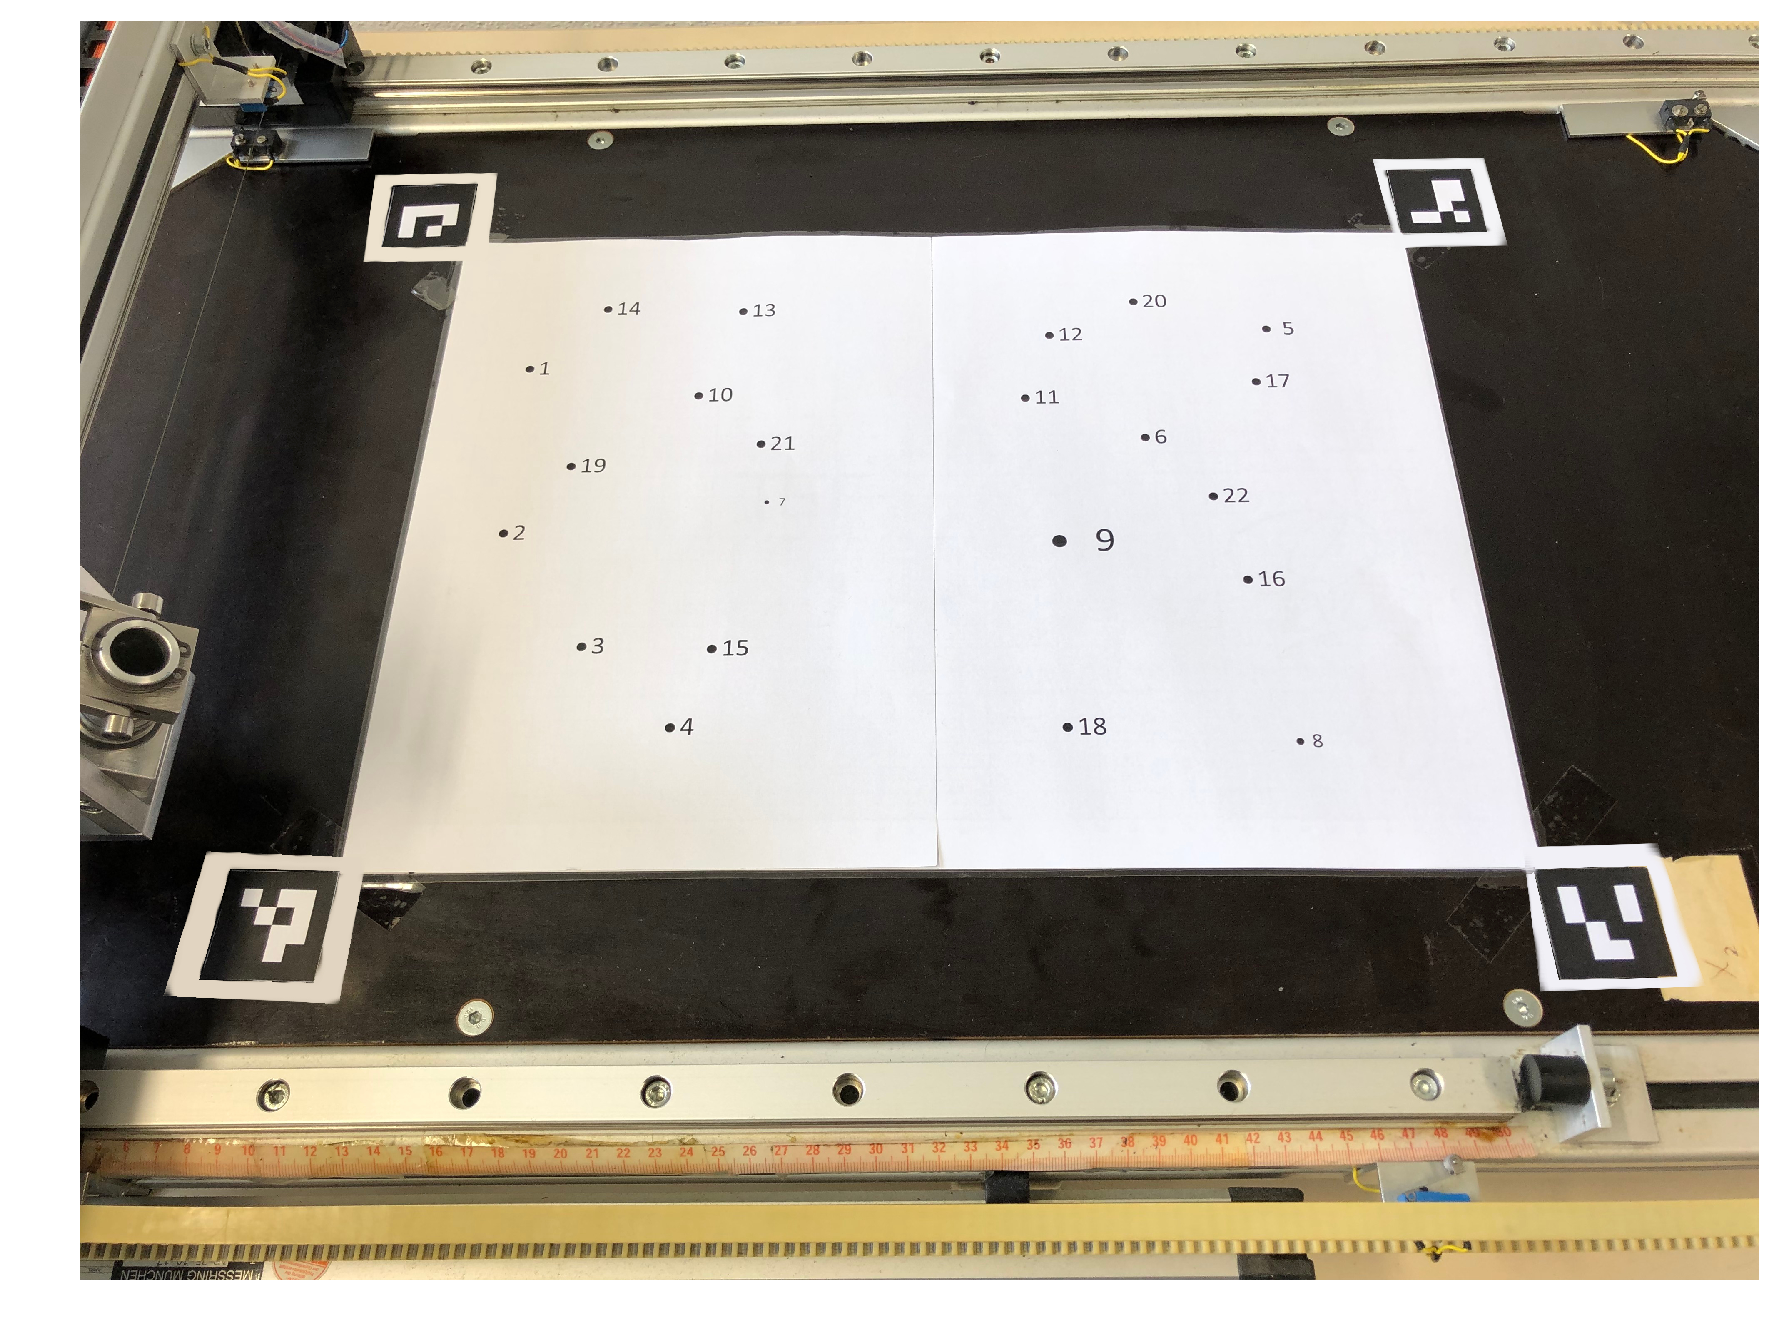

In [5]:
imshow(cm_img)

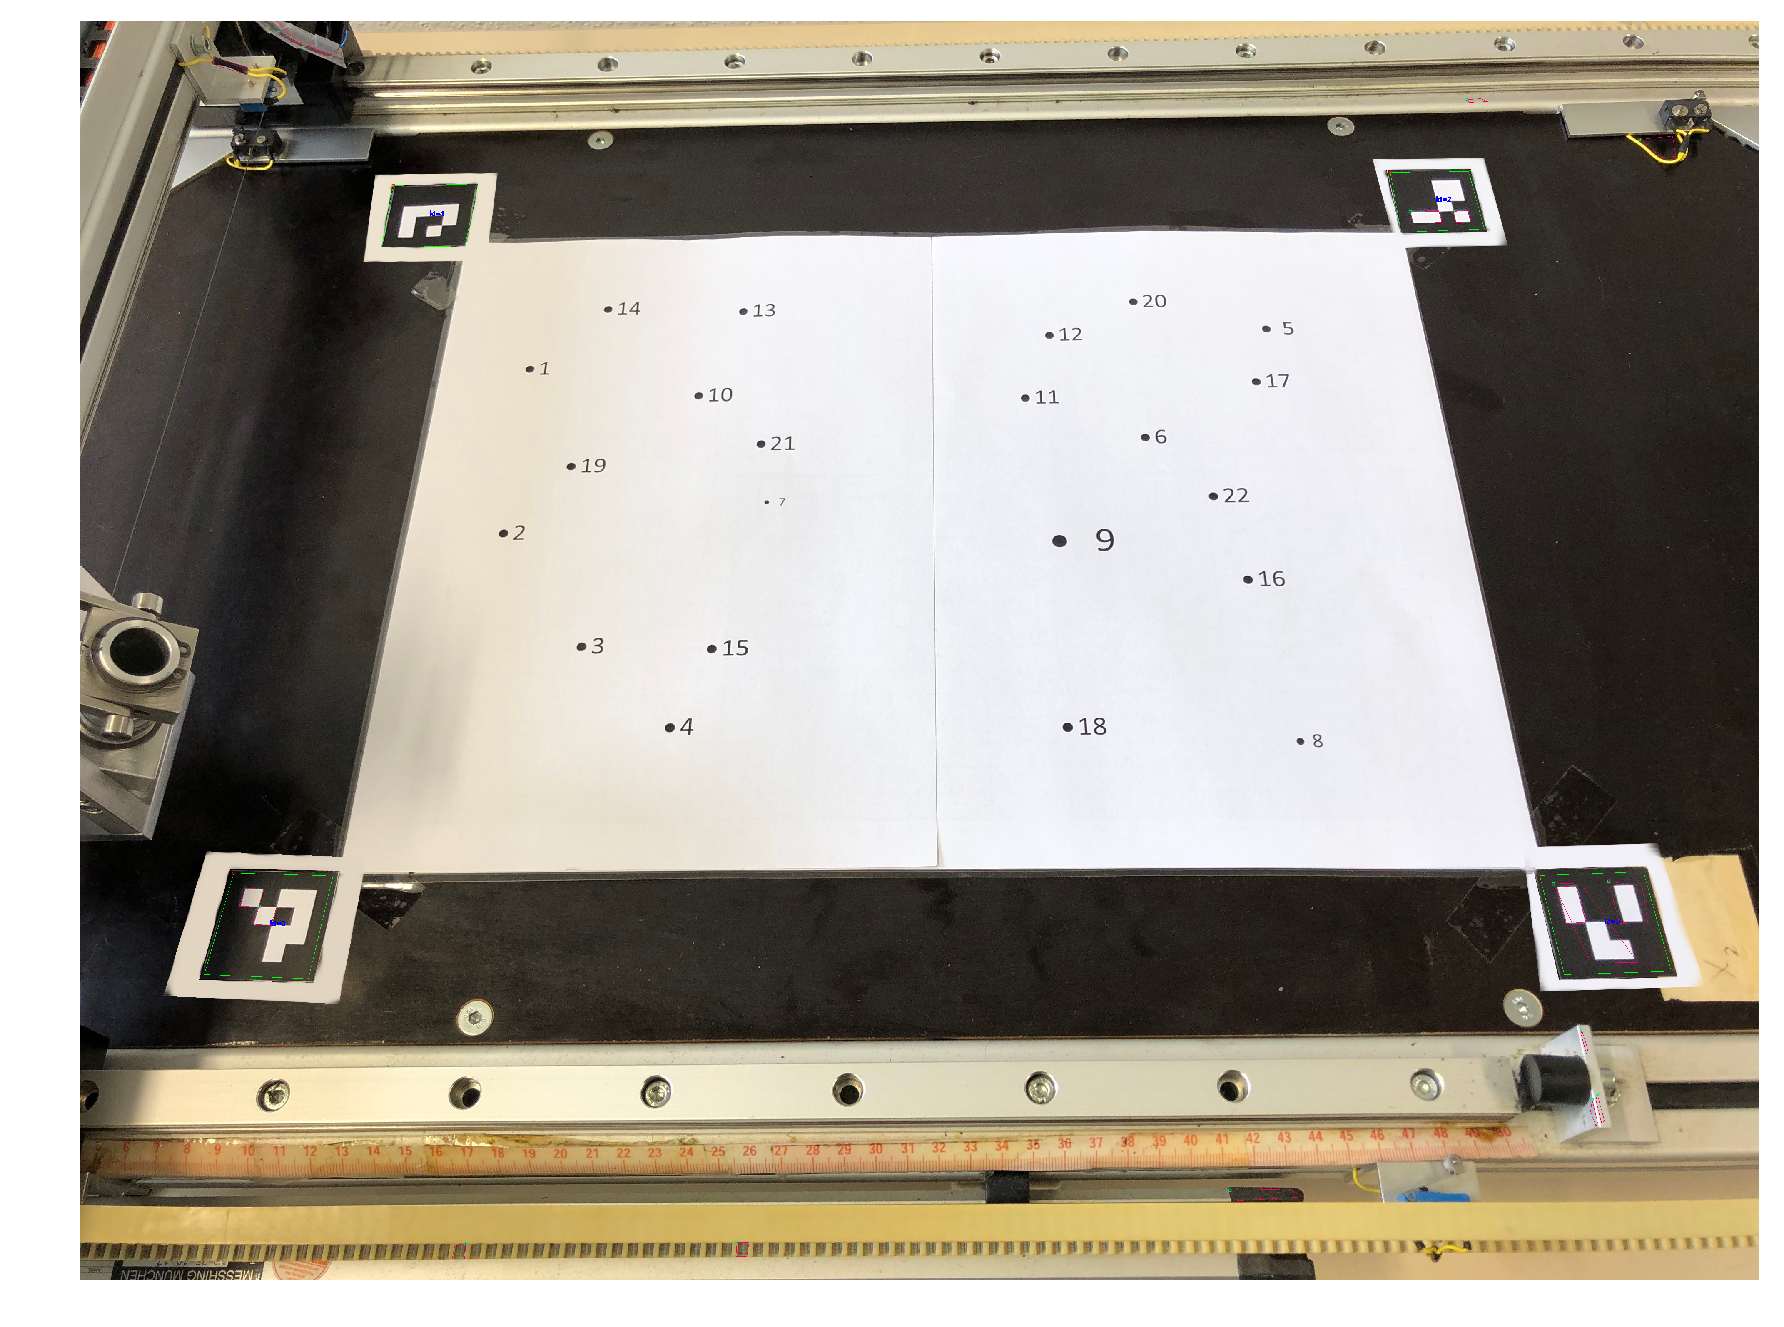

In [6]:
parameters =  cv2.aruco.DetectorParameters_create()
parameters.cornerRefinementMethod = cv2.aruco.CORNER_REFINE_SUBPIX
corners, ids, rejectedImgPoints = cv2.aruco.detectMarkers(cm_img_gray, ar_dict, parameters=parameters)
frame_markers = cv2.aruco.drawDetectedMarkers(cm_img.copy(), corners, ids)
frame_markers = cv2.aruco.drawDetectedMarkers(frame_markers, rejectedImgPoints, borderColor=(100, 0, 240))

imshow(frame_markers)

In [7]:
corners

[array([[[3146.    ,  363.    ],
         [3334.    ,  361.    ],
         [3372.    ,  499.    ],
         [3171.7004,  507.3677]]], dtype=float32), array([[[ 369., 2046.],
         [ 607., 2053.],
         [ 548., 2300.],
         [ 298., 2290.]]], dtype=float32), array([[[3505., 2052.],
         [3754., 2043.],
         [3821., 2282.],
         [3564., 2290.]]], dtype=float32), array([[[751.549  , 395.0163 ],
         [955.35077, 390.6148 ],
         [924.46893, 540.29803],
         [723.8874 , 543.25836]]], dtype=float32)]

In [8]:
ids

array([[2],
       [0],
       [3],
       [1]], dtype=int32)

In [9]:
h,w = cm_img_gray.shape
middle = np.float32([h/2, w/2])
ids2point = {}

for mid, m_corners in zip(np.squeeze(ids), np.squeeze(corners)):
    ds = np.sqrt(np.sum((m_corners-middle)**2, axis=1)) # distance of corner points to center of image
    ids2point[mid] = m_corners[np.argmin(ds)]

In [17]:
width, height = 2*21.0, 29.7 # size of area marked by inner points of aruco markers in cm
dst_h, dst_w = int(height*50), int(width*50) 

src_pts = np.array([ids2point[i] for i in range(4)])
dst_pts = np.array([[0, dst_h],
                    [0, 0],
                    [dst_w, 0],
                    [dst_w, dst_h]], dtype="float32")

M = cv2.getPerspectiveTransform(src_pts, dst_pts)

In [18]:
warped = cv2.warpPerspective(cm_img_gray, M, (dst_w, dst_h))

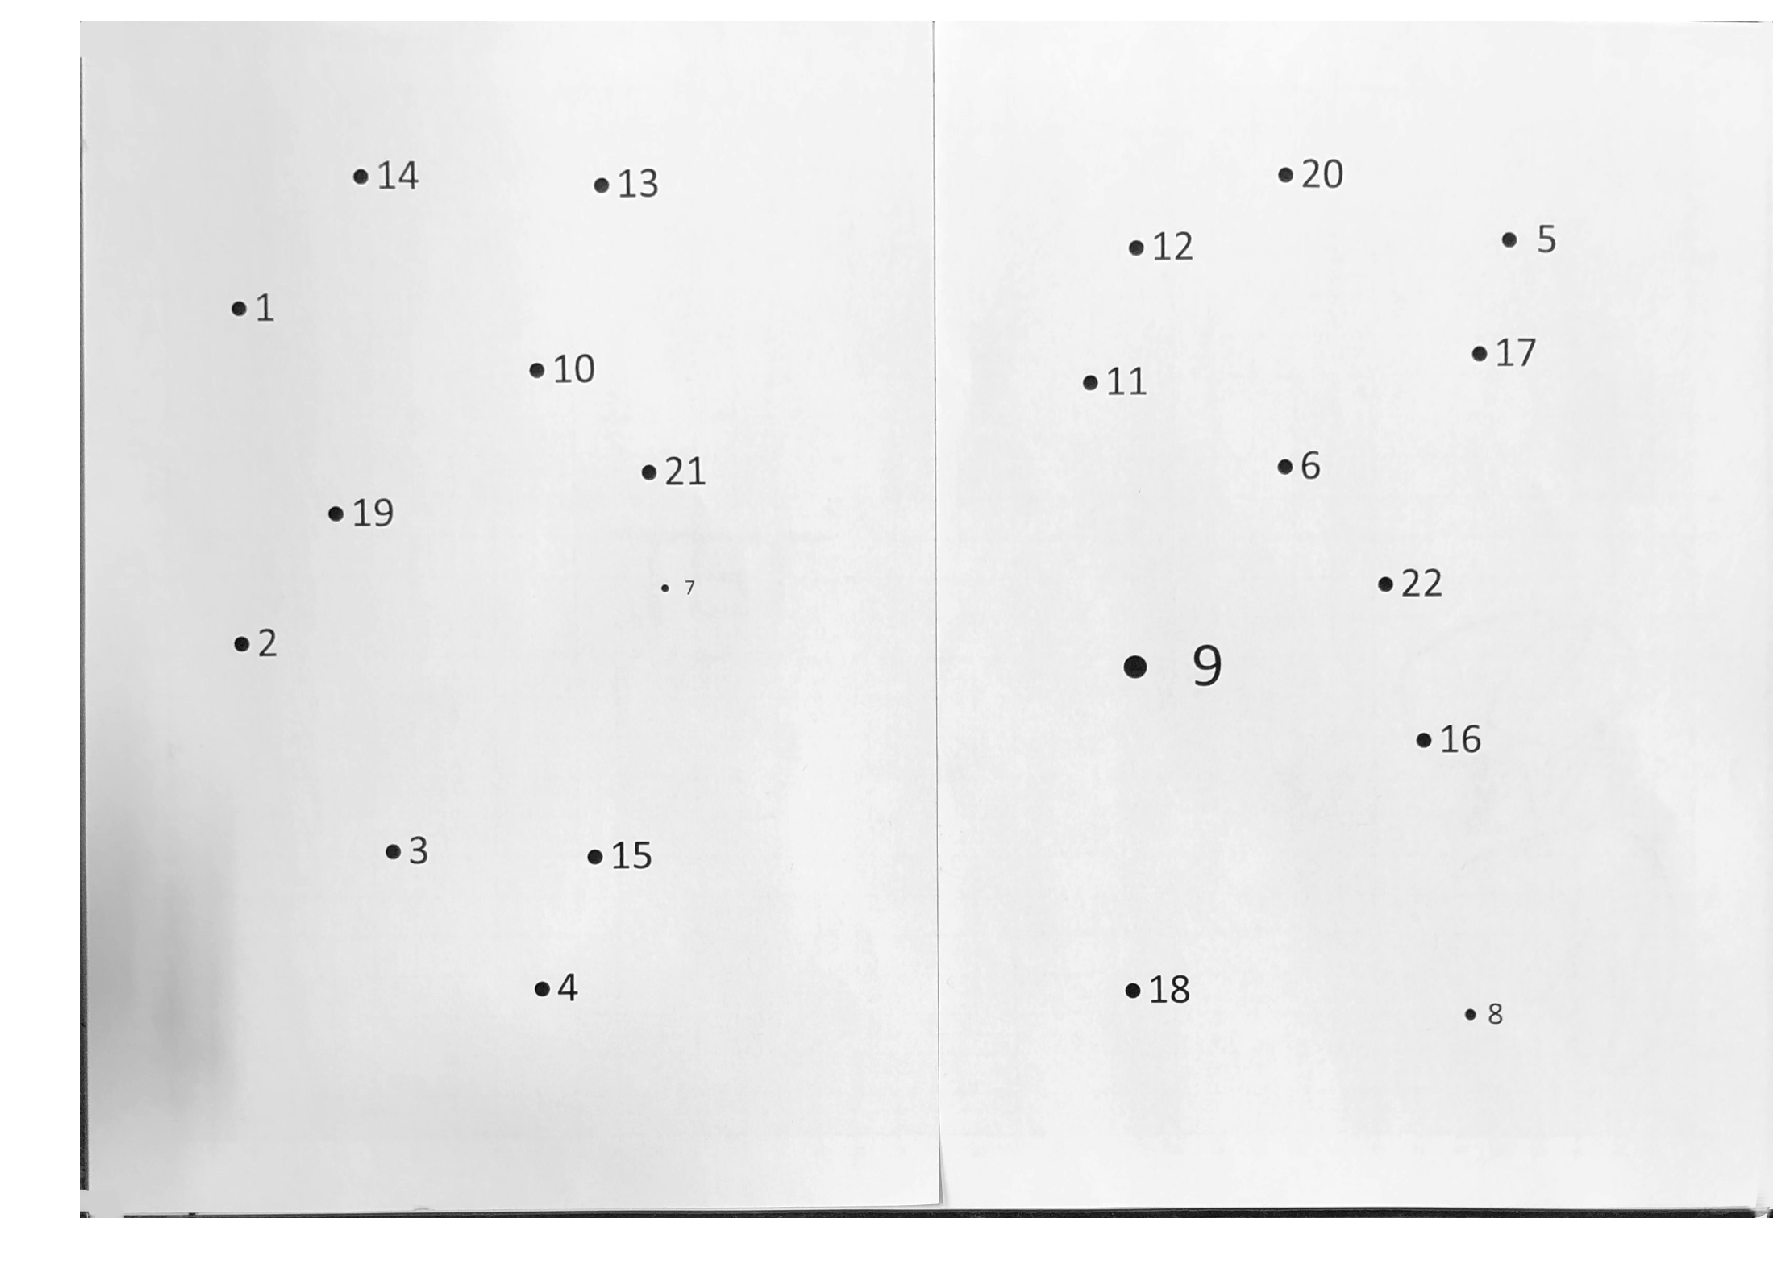

In [19]:
imshow(warped)

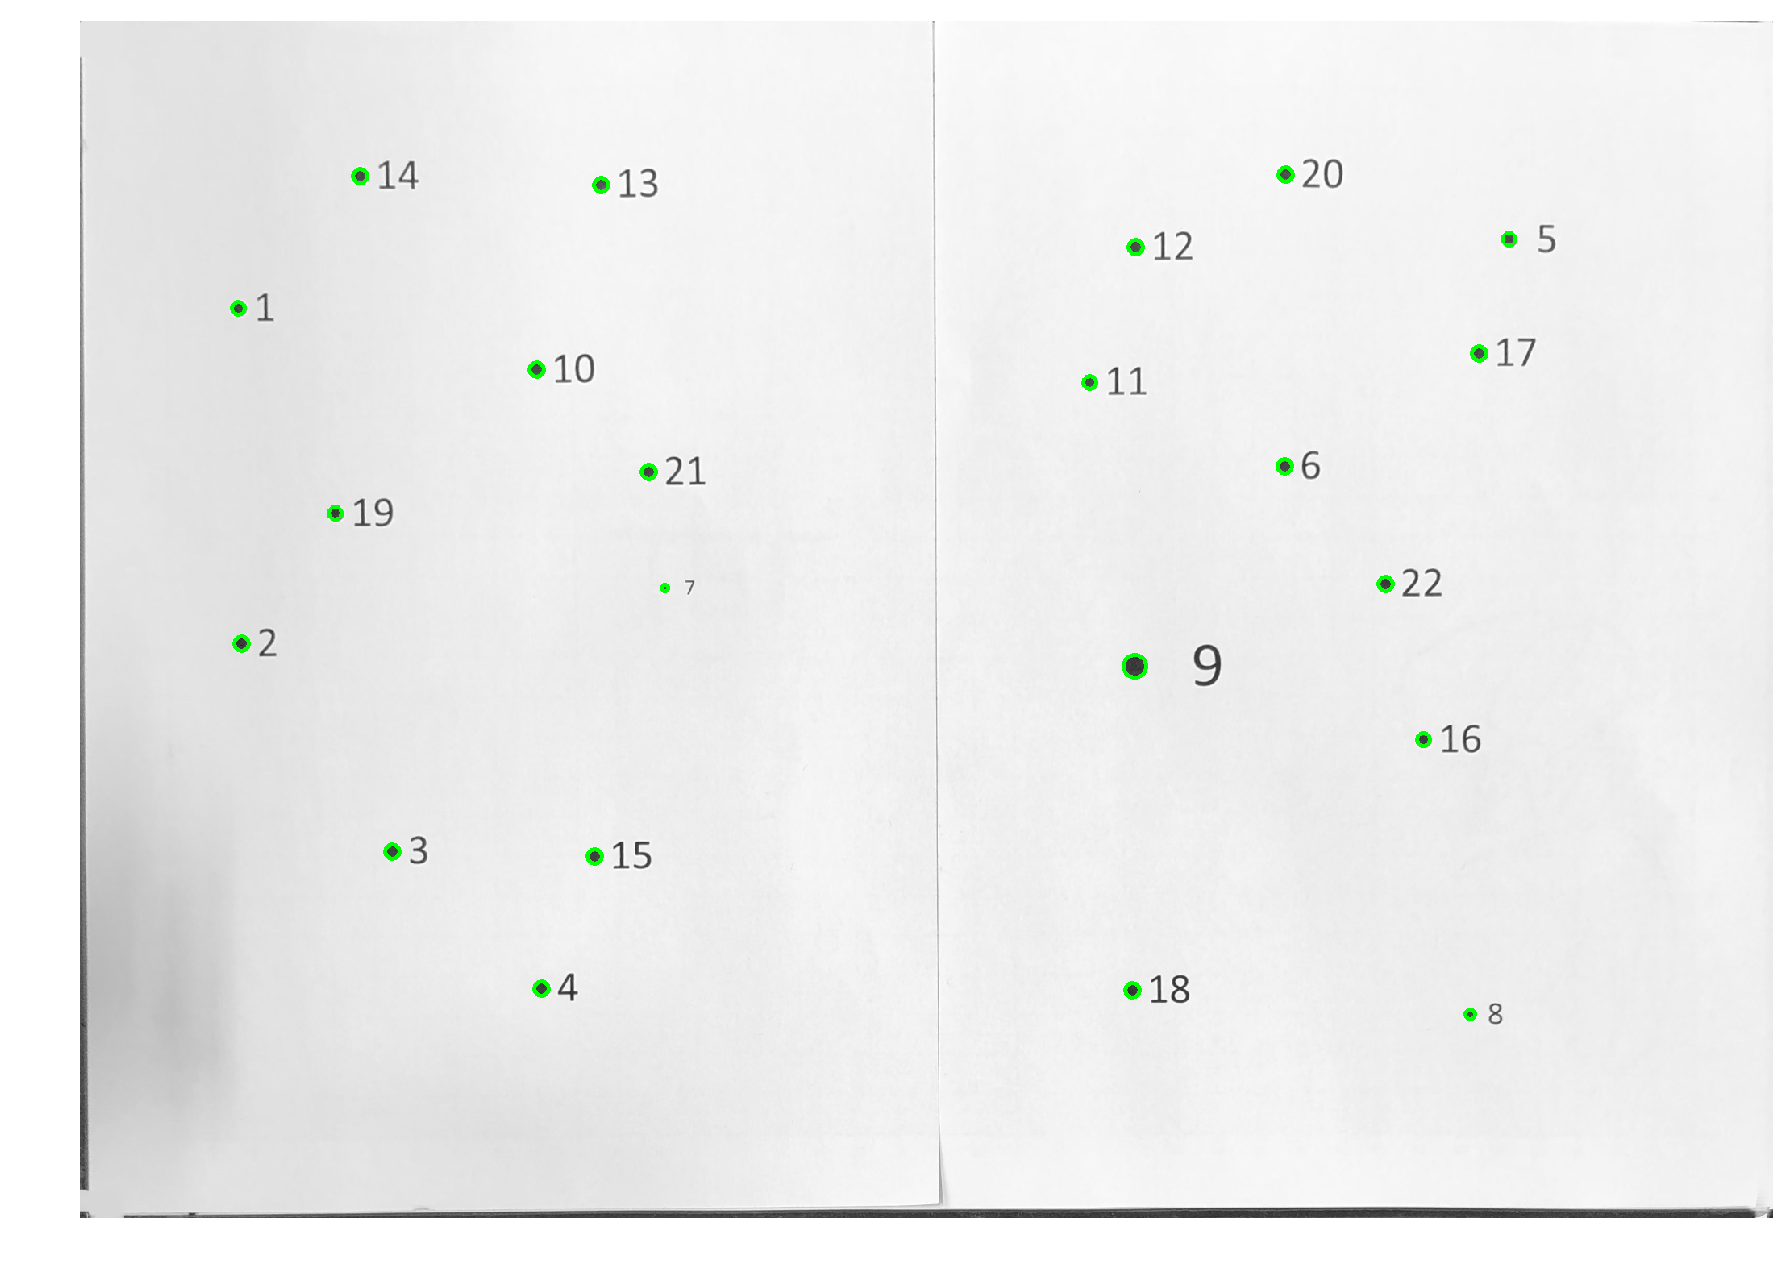

In [78]:
circles = cv2.HoughCircles(cv2.GaussianBlur(warped, (5, 5), 2.), cv2.HOUGH_GRADIENT, 1., 
                           minDist=10, param1=100, param2=15, 
                           minRadius=0, maxRadius=dst_w//100)[0]

# draw detections
res_img = cv2.cvtColor(warped.copy(), cv2.COLOR_GRAY2BGR)

for x, y, r in circles.astype(np.int):
    
    Y, X = np.ogrid[:warped.shape[0], :warped.shape[1]]
    mask = np.sqrt((X - x)**2 + (Y - y)**2) <= r
    
    # only accept circles that are mostly filled with black
    if np.median(warped[mask]) < 120: 
        cv2.circle(res_img, (x, y), r, (0, 255, 0), 4)
imshow(res_img)